In [78]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch import FloatTensor as tensor
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
import csv
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

In [79]:
data_size=600
batch_size = 10
epoches = 300
data_min_width = 50
data_min_height = 30

In [80]:
data=[]

In [81]:
dir_path_open = './opened'
for (root, directories, files) in os.walk(dir_path_open):
    i = 1
    for file in files:
        file_path = os.path.join(root, file)
        img = cv2.imread(file_path)
        if img.shape[0] < data_min_height or img.shape[1] < data_min_width or img.shape[2] != 3:
            continue
        data.append((np.array(transforms.ToTensor()(cv2.resize(img, (64, 48)))), np.array([0])))
        print('\r', i, end='')
        i += 1
        if i == 336:
            break

print()

dir_path_open = './closed'
for (root, directories, files) in os.walk(dir_path_open):
    i = 1
    for file in files:
        file_path = os.path.join(root, file)
        img = cv2.imread(file_path)
        if img.shape[0] < data_min_height or img.shape[1] < data_min_width or img.shape[2] != 3:
            continue
        data.append((np.array(transforms.ToTensor()(cv2.resize(img, (64, 48)))), np.array([1])))
        print('\r', i, end='')
        i += 1
        if i == 336:
            break

 335
 335

In [82]:
random.shuffle(data)
train, test=data[:600], data[600:]
x_train, y_train = [], []
x_test, y_test = [], []

for x, y in train:
    x_train.append(x)
    y_train.append(y)
for x, y in test:
    x_test.append(x)
    y_test.append(y)

x_train=tensor(np.array(x_train))
y_train=tensor(np.array(y_train))
x_test=tensor(np.array(x_test))
y_test=tensor(np.array(y_test))

In [83]:
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

600 600
70 70


In [84]:
x_train.shape

torch.Size([600, 3, 48, 64])

In [85]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # 64, 48, 3 -> 32, 24, 16
        self.layer1 = nn.Sequential(
            torch.nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # 32, 24, 16 -> 16, 12, 32
        self.layer2 = nn.Sequential(
            torch.nn.Conv2d(16, 64, kernel_size=5, stride=1, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=4, stride=4)
        )
        # # 16, 12, 32 -> 8, 6, 64
        # self.layer3 = nn.Sequential(
        #     torch.nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
        #     torch.nn.ReLU(),
        #     torch.nn.MaxPool2d(kernel_size=2, stride=2)
        # )

        # 8, 6, 64 -> 8*6*64=3072
        # 3072 -> 384 -> 48 -> 8 -> 1
        self.layer4 = nn.Sequential(
            nn.Linear(3072, 300),
            nn.ReLU(),
            nn.Linear(300, 20),
            nn.ReLU(),
            nn.Linear(20, 1),
            nn.Sigmoid()
        )

        # self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        # x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.layer4(x)
        return x

model = CNN()
optimizer = optim.SGD(model.parameters(), lr=0.005)

In [86]:
datasets = TensorDataset(x_train, y_train)
dataloader = DataLoader(datasets, batch_size=batch_size, shuffle=True)

In [87]:
train_cost, test_cost = [], []
for epoch in range(epoches + 1):
    cost_sum = 0
    for batch_ind, sample in enumerate(dataloader):
        x, y = sample
        prediction = model(x)
        cost = F.binary_cross_entropy(prediction, y)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        cost_sum += cost.item()
    if epoch % 10 == 0:
        print("epoch {} : {:.5f}".format(epoch, cost_sum / int(data_size / batch_size)))
    prediction = model(x_test)
    cost = F.binary_cross_entropy(prediction, y_test)
    test_cost.append(cost.item())
    train_cost.append(cost_sum / int(data_size / batch_size))

epoch 0 : 0.69495
epoch 10 : 0.68966
epoch 20 : 0.67143
epoch 30 : 0.38330
epoch 40 : 0.24283
epoch 50 : 0.18120
epoch 60 : 0.15342
epoch 70 : 0.15229
epoch 80 : 0.10887
epoch 90 : 0.09418
epoch 100 : 0.07936
epoch 110 : 0.05998
epoch 120 : 0.04734
epoch 130 : 0.03529
epoch 140 : 0.03307
epoch 150 : 0.02337
epoch 160 : 0.01887
epoch 170 : 0.01730
epoch 180 : 0.01016
epoch 190 : 0.01024
epoch 200 : 0.00723
epoch 210 : 0.00453
epoch 220 : 0.00558
epoch 230 : 0.01060
epoch 240 : 0.00388
epoch 250 : 0.00337
epoch 260 : 0.00217
epoch 270 : 0.00191
epoch 280 : 0.00174
epoch 290 : 0.00167
epoch 300 : 0.00124


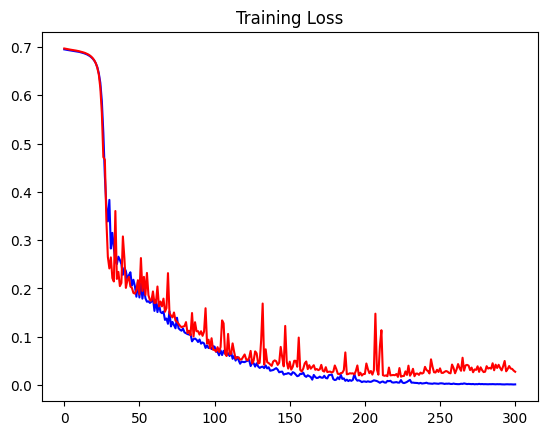

In [89]:
train_cost = np.array(train_cost)
plt.plot(np.arange(len(train_cost)), train_cost, color='blue')
test_cost = np.array(test_cost)
plt.plot(np.arange(len(test_cost)), test_cost, color='red')
plt.title('Training Loss')
plt.show()
torch.save(model.state_dict(), 'model.pth')

In [90]:
prediction = model(x_test)

In [91]:
prediction

tensor([[1.0000e+00],
        [4.7551e-06],
        [3.0487e-09],
        [1.0143e-01],
        [7.6163e-04],
        [1.0000e+00],
        [2.2122e-08],
        [5.6977e-01],
        [1.0000e+00],
        [1.0000e+00],
        [9.9990e-01],
        [1.0000e+00],
        [9.9668e-01],
        [1.1336e-08],
        [1.1669e-07],
        [9.9611e-01],
        [9.9998e-01],
        [1.9027e-01],
        [2.8067e-07],
        [1.0607e-10],
        [4.4156e-10],
        [9.8107e-01],
        [9.9866e-01],
        [1.1356e-11],
        [1.0000e+00],
        [1.0627e-07],
        [2.0144e-14],
        [9.9863e-01],
        [1.0025e-03],
        [1.0000e+00],
        [9.9707e-01],
        [8.2179e-15],
        [9.9968e-01],
        [9.9999e-01],
        [1.0000e+00],
        [3.0280e-11],
        [2.0703e-04],
        [4.4295e-07],
        [1.0000e+00],
        [1.6026e-09],
        [1.0000e+00],
        [4.3574e-10],
        [1.0000e+00],
        [7.9357e-07],
        [9.9991e-01],
        [1